In [1]:
import pandas as pd

In [2]:
path = './data/18-10-28_names.csv'

In [3]:
df = pd.read_csv(path, sep='\\', encoding = "ISO-8859-1")

In [4]:
df = df.rename(columns={"frame.time_relative": "time",
                        "_ws.col.Protocol": "protocol",
                        "frame.len": "len",
                        "_ws.col.Info": "info"})

In [5]:
df.head()

,time,eth.src,eth.src_resolved,eth.dst,eth.dst_resolved,ip.src,ip.src_host,ip.dst,ip.dst_host,protocol,len,info
0,0.000000,f4:f2:6d:93:51:f1,Tp-LinkT_93:51:f1,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.108,192.168.1.108,192.168.1.1,192.168.1.1,DNS,74,Standard query 0x0002 A 0.pool.ntp.org
1,0.018517,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,f4:f2:6d:93:51:f1,Tp-LinkT_93:51:f1,192.168.1.1,192.168.1.1,192.168.1.108,192.168.1.108,DNS,540,Standard query response 0x0002 A 0.pool.ntp.or...
2,0.019904,f4:f2:6d:93:51:f1,Tp-LinkT_93:51:f1,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.108,192.168.1.108,116.206.80.123,116.206.80.123,NTP,90,"NTP Version 3, client"
3,0.028933,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,f4:f2:6d:93:51:f1,Tp-LinkT_93:51:f1,116.206.80.123,116.206.80.123,192.168.1.108,192.168.1.108,NTP,90,"NTP Version 3, server"
4,0.085444,b4:75:0e:ec:e5:a9,BelkinIn_ec:e5:a9,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.245,192.168.1.245,52.203.179.71,52.203.179.71,TLSv1.2,97,Application Data


<AxesSubplot:>

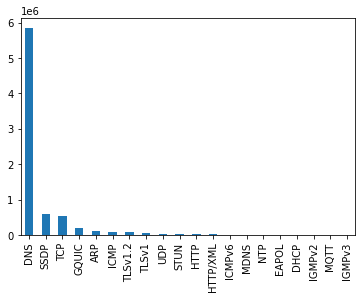

In [6]:
df['protocol'].value_counts()[:20].plot(kind='bar')

In [7]:
ip_sources = df['ip.src'].value_counts()
len(ip_sources)

485

<AxesSubplot:>

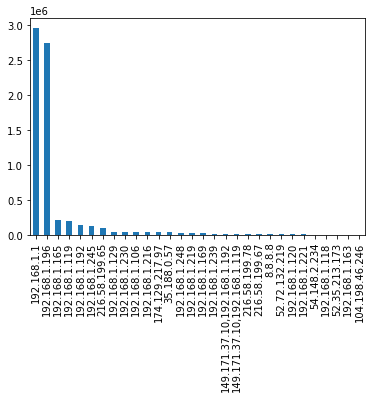

In [8]:
ip_sources[:30].plot(kind='bar')

In [9]:
ip_destinations = df['ip.dst'].value_counts()
len(ip_destinations)

645

<AxesSubplot:>

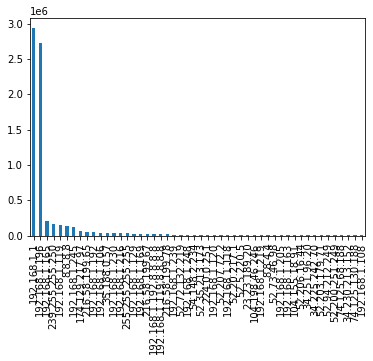

In [10]:
ip_destinations[:50].plot(kind='bar')

In [11]:
len(df['eth.src'].value_counts())

28

<AxesSubplot:>

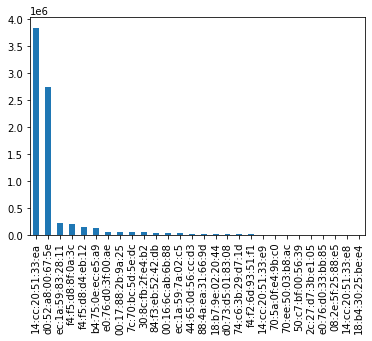

In [12]:
df['eth.src'].value_counts()[:50].plot(kind='bar')

<AxesSubplot:>

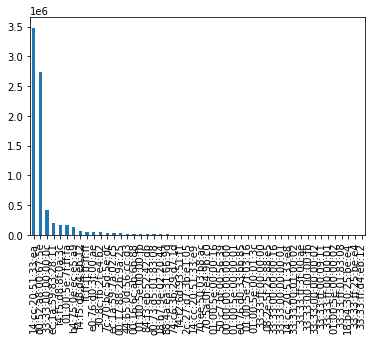

In [13]:
df['eth.dst'].value_counts()[:50].plot(kind='bar')

<AxesSubplot:>

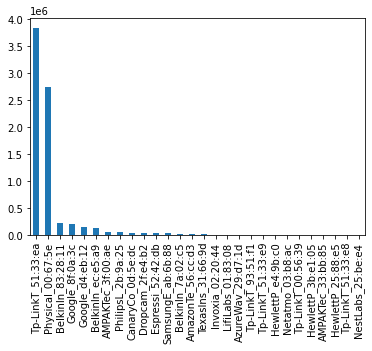

In [14]:
df['eth.src_resolved'].value_counts()[:50].plot(kind='bar')

<AxesSubplot:>

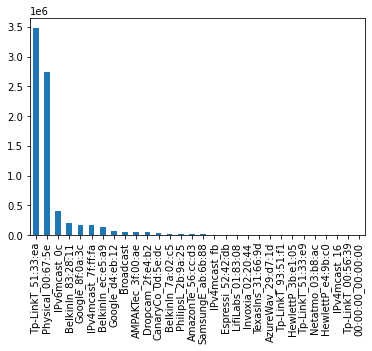

In [15]:
df['eth.dst_resolved'].value_counts()[:30].plot(kind='bar')

In [16]:
df['ip.dst'].value_counts()

192.168.1.1                    2930953
192.168.1.196                  2731429
192.168.1.165                   199126
239.255.255.250                 165912
192.168.1.119                   150501
                                ...   
134.0.16.1                           1
139.112.153.36                       1
192.168.1.112,163.172.77.29          1
185.103.216.7                        1
103.114.160.109                      1
Name: ip.dst, Length: 645, dtype: int64

Next: check the packet that raised a warning when running tshark (1479336)

mac name resolution

### Packets that raise a warning when running tshark

In [17]:
df.iloc[1479335]

time                                               41421
eth.src                                d0:52:a8:00:67:5e
eth.src_resolved                       Physical_00:67:5e
eth.dst                                14:cc:20:51:33:ea
eth.dst_resolved                       Tp-LinkT_51:33:ea
ip.src                                     192.168.1.196
ip.src_host                                192.168.1.196
ip.dst                                       192.168.1.1
ip.dst_host                                  192.168.1.1
protocol                                             DNS
len                                                   72
info                Standard query 0x5231 A pool.ntp.org
Name: 1479335, dtype: object

In [18]:
df.iloc[1479335]['info']

'Standard query 0x5231 A pool.ntp.org'

Seems like the info column is too long (>500)

### Now we try to split the dataset based on IP addresses of the IoT devices

#### Top 30 source private IP addresses

<AxesSubplot:>

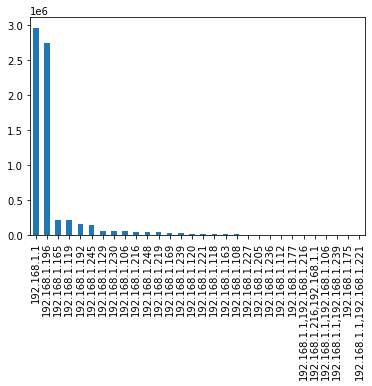

In [19]:
ip_sources[ip_sources.index.str.startswith('192.168.')][:30].plot(kind='bar')

#### Top 30 source public IP addresses

<AxesSubplot:>

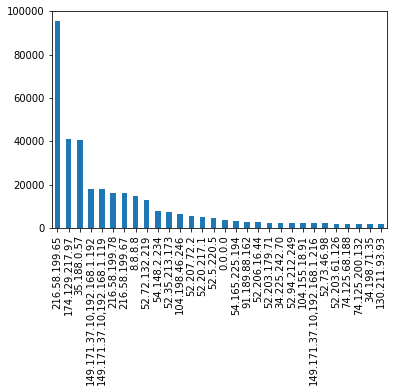

In [20]:
ip_sources[~ ip_sources.index.str.startswith('192.168.')][:30].plot(kind='bar')

#### 192.168.1.118 is a random IoT device, try to understand with who it communicates in the LAN

In [21]:
df[df['ip.src'] == '192.168.1.118']['eth.src_resolved'].value_counts()

LifiLabs_01:83:08    7624
Name: eth.src_resolved, dtype: int64

192.168.1.118 is probably a LIFX smart lamp (its MAC address is from Lifilabs).

In [22]:
df[df['ip.dst'] == '192.168.1.118']['eth.src_resolved'].value_counts()

Tp-LinkT_51:33:ea    7137
Name: eth.src_resolved, dtype: int64

It looks like the device with MAC 51:33:ea is the router, of the brand TP-Link

In [23]:
destinations = df[df['ip.src'] == '192.168.1.118']['ip.dst']
destinations

246        104.198.46.246
251         192.168.1.255
252        104.198.46.246
420        104.198.46.246
948        104.198.46.246
                ...      
7719580    104.198.46.246
7720648    104.198.46.246
7720663    104.198.46.246
7720682     192.168.1.255
7720683    104.198.46.246
Name: ip.dst, Length: 7624, dtype: object

In [24]:
destinations[destinations.str.startswith('192.168.')].value_counts()

192.168.1.255    1619
192.168.1.1       441
Name: ip.dst, dtype: int64

There are only 2 LAN IP destinations for 192.168.1.118: 192.168.1.1 and 192.168.1.255 (I think these are the router private IP address and the LAN broadcast IP address)

In [25]:
df[(df['ip.src'] == '192.168.1.118') & (df['ip.dst'] == '192.168.1.1')]['protocol'].value_counts()

DNS     437
DHCP      4
Name: protocol, dtype: int64

As we can see this communication was only used for DNS and DHCP

In [26]:
df[(df['ip.src'] == '192.168.1.118') & (df['ip.dst'] == '192.168.1.255')]['protocol'].value_counts()

UDP             1081
ADwin Config     538
Name: protocol, dtype: int64

???

In [27]:
destinations[~ destinations.str.startswith('192.168.')].value_counts()

104.198.46.246    4832
8.8.8.8            439
216.239.32.15       39
129.250.35.250      17
43.245.48.27        15
                  ... 
103.35.80.142        1
207.148.72.47        1
91.235.212.22        1
45.76.244.202        1
172.104.55.191       1
Name: ip.dst, Length: 68, dtype: int64

As we can see, 192.168.1.118 mainly communicates with 104.198.46.246

According to a reverse IP lookup, the latter is owned by Google.

#### Now try to extract the traffic related to 192.168.1.118

In [28]:
df[(df['ip.src'] == '192.168.1.118') | (df['ip.dst'] == '192.168.1.118') | (df['ip.dst'] == '255.255.255.255')]
# Note that we should also include multicasts that comprise 192.168.1.118, and broadcast

,time,eth.src,eth.src_resolved,eth.dst,eth.dst_resolved,ip.src,ip.src_host,ip.dst,ip.dst_host,protocol,len,info
235,1.773326,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
242,4.776186,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
245,6.553746,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,d0:73:d5:01:83:08,LifiLabs_01:83:08,104.198.46.246,104.198.46.246,192.168.1.118,192.168.1.118,TLSv1,91,Application Data
246,6.683274,d0:73:d5:01:83:08,LifiLabs_01:83:08,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.118,192.168.1.118,104.198.46.246,104.198.46.246,TCP,54,21210 â 56700 [ACK] Seq=1 Ack=38 Win=1460 Len=0
250,6.857155,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,d0:73:d5:01:83:08,LifiLabs_01:83:08,104.198.46.246,104.198.46.246,192.168.1.118,192.168.1.118,TLSv1,123,Application Data
...,...,...,...,...,...,...,...,...,...,...,...,...
7720806,86383.896253,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
7720823,86386.896360,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
7720848,86389.896552,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175
7720880,86392.896361,84:f3:eb:52:42:db,Espressi_52:42:db,ff:ff:ff:ff:ff:ff,Broadcast,192.168.1.219,192.168.1.219,255.255.255.255,255.255.255.255,UDP,217,49154 â 6666 Len=175


#### LAN packets

In [29]:
df[df['ip.src'].str.startswith('192.168.') & df['ip.dst'].str.startswith('192.168.')]
# Note that we should also include other private prefixes than 192.168.

,time,eth.src,eth.src_resolved,eth.dst,eth.dst_resolved,ip.src,ip.src_host,ip.dst,ip.dst_host,protocol,len,info
0,0.000000,f4:f2:6d:93:51:f1,Tp-LinkT_93:51:f1,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.108,192.168.1.108,192.168.1.1,192.168.1.1,DNS,74,Standard query 0x0002 A 0.pool.ntp.org
1,0.018517,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,f4:f2:6d:93:51:f1,Tp-LinkT_93:51:f1,192.168.1.1,192.168.1.1,192.168.1.108,192.168.1.108,DNS,540,Standard query response 0x0002 A 0.pool.ntp.or...
118,0.761859,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,192.168.1.1,192.168.1.1,DNS,68,Standard query 0x05b6 A xbcs.net
119,0.765004,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,84,Standard query response 0x05b6 A xbcs.net A 18...
120,0.765041,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.1,192.168.1.1,192.168.1.165,192.168.1.165,DNS,84,Standard query response 0x05b6 A xbcs.net A 18...
...,...,...,...,...,...,...,...,...,...,...,...,...
7720843,86388.845446,ec:1a:59:83:28:11,BelkinIn_83:28:11,b4:75:0e:ec:e5:a9,BelkinIn_ec:e5:a9,192.168.1.165,192.168.1.165,192.168.1.245,192.168.1.245,TCP,66,"3147 â 49153 [FIN, ACK] Seq=321 Ack=169 Win=..."
7720844,86388.846849,ec:1a:59:83:28:11,BelkinIn_83:28:11,b4:75:0e:ec:e5:a9,BelkinIn_ec:e5:a9,192.168.1.165,192.168.1.165,192.168.1.245,192.168.1.245,TCP,66,3147 â 49153 [ACK] Seq=322 Ack=170 Win=5840 ...
7720845,86388.847918,b4:75:0e:ec:e5:a9,BelkinIn_ec:e5:a9,ec:1a:59:83:28:11,BelkinIn_83:28:11,192.168.1.245,192.168.1.245,192.168.1.165,192.168.1.165,TCP,66,49153 â 3147 [ACK] Seq=170 Ack=322 Win=5792 ...
7720882,86393.648771,ec:1a:59:83:28:11,BelkinIn_83:28:11,14:cc:20:51:33:ea,Tp-LinkT_51:33:ea,192.168.1.165,192.168.1.165,192.168.1.1,192.168.1.1,DNS,68,Standard query 0x00e1 A xbcs.net


In [30]:
ip_destinations[ip_destinations.index.str.startswith('192.168.')]
# Note the bug with some address fields that contain 2 addresses

192.168.1.1                     2930953
192.168.1.196                   2731429
192.168.1.165                    199126
192.168.1.119                    150501
192.168.1.245                    127575
                                 ...   
192.168.1.175,91.189.91.157           1
192.168.1.221,34.231.76.82            1
192.168.1.216,52.193.63.245           1
192.168.1.239,69.164.202.202          1
192.168.1.112,163.172.77.29           1
Name: ip.dst, Length: 207, dtype: int64

In [31]:
ip_sources[ip_sources.index.str.startswith('192.168.')]

192.168.1.1                    2958368
192.168.1.196                  2740730
192.168.1.165                   214158
192.168.1.119                   202539
192.168.1.192                   149705
192.168.1.245                   132001
192.168.1.129                    48454
192.168.1.230                    46997
192.168.1.106                    45635
192.168.1.216                    44682
192.168.1.248                    37324
192.168.1.219                    37271
192.168.1.169                    27012
192.168.1.239                    21065
192.168.1.120                    11099
192.168.1.221                    10238
192.168.1.118                     7624
192.168.1.163                     7168
192.168.1.108                     5614
192.168.1.227                     2293
192.168.1.205                     2002
192.168.1.236                     1950
192.168.1.112                     1695
192.168.1.177                     1338
192.168.1.1,192.168.1.216         1187
192.168.1.216,192.168.1.1